In [2]:
!tree ../dataset

../dataset
├── en_espanol
│   ├── docx2txt.py
│   ├── Второй_жанр_исходная.txt
│   └── Первый_жанр_исходная.txt
├── Второй_жанр_исходная.txt
├── Первый_жанр_исходная.txt
├── Сокращение по частям речи
│   ├── 1.Первый жанр исходная выборка.txt
│   ├── 2.Первый жанр без клауз, включающих наречия.txt
│   ├── 3.Первый жанр без клауз, включающих глаголы.txt
│   ├── 4. Первый жанр без клауз, включающих глаголы и наречия.txt
│   ├── Без прилагательных второй жанр.txt
│   ├── Без прилагательных первый жанр.txt
│   └── Случайные выборки.txt
└── сокращение по частотности
    ├── 1а_ без сокращений.txt
    ├── 1б_Изъяты лексемы с частотой выше 100.txt
    ├── 1в_Изъяты лексемы с частотой выше 49.txt
    ├── 1г_Изъяты лексемы с частотой выше 29.txt
    ├── 1д_Изъяты лексемы с частотой выше 9.txt
    ├── 2а_ без сокращений.txt
    ├── 2б_Изъяты лексемы с частотой выше 100.txt
    ├── 2в_Изъяты лексемы с частотой выше 49.txt
    ├── 2г_Изъяты лексемы с частотой выше 29.txt
    └── 2д_Изъяты лексемы 

In [1]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from isanlp import PipelineCommon
from isanlp.simple_text_preprocessor import SimpleTextPreprocessor
from isanlp.processor_razdel import ProcessorRazdel
import re
import razdel 
from isanlp.pipeline_common import PipelineCommon
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from isanlp import PipelineCommon
from isanlp.simple_text_preprocessor import SimpleTextPreprocessor
from isanlp.processor_razdel import ProcessorRazdel
import re
import razdel

import torch
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np


/workspace/notebooks/Carlos/fine_tunig_project/mi_entorno/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-21 11:25:07.363380: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# 1. Carga de datos y etiquetado
def cargar_datos(archivo, etiqueta):
    with open(archivo, 'r', encoding='utf-8') as f:
        textos = f.readlines()
    return [(texto.strip(), etiqueta) for texto in textos]


def clean_split_data(datos):
    """
    limpia los datos y los split
    """
    datos_procesados = [
        (oracion.text, etiqueta)
        for texto, etiqueta in datos
        for oracion in razdel.sentenize(re.sub(r'\[.*?\]', '', texto).strip())
    ]
    return datos_procesados


tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')
#max_length = 256   # o un valor que consideres adecuado.
max_length = 512 
class GeneroDataset(Dataset):
    """
    tokeniza los datos
    """
    
    def __init__(self, datos):
        self.datos = datos

    def __len__(self):
        return len(self.datos)

    def __getitem__(self, idx):
        texto, etiqueta = self.datos[idx]
        tokens = tokenizer(texto,
                           padding='max_length',
                           truncation=True,
                           return_tensors='pt',
                           max_length=max_length)
        #print(f"Forma del tensor tokenizado: {tokens['input_ids'].shape}")
        return tokens, torch.tensor(etiqueta)


datos_genero1 = cargar_datos('../dataset/Первый_жанр_исходная.txt', 0) # Etiqueta 0 para Género 1
datos_genero2 = cargar_datos('../dataset/Второй_жанр_исходная.txt', 1) # Etiqueta 1 para Género 2
datos = datos_genero1 + datos_genero2


/workspace/notebooks/Carlos/fine_tunig_project/mi_entorno/lib/python3.8/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:

datos_procesados =  clean_split_data(datos)


In [7]:
# 3. Preparación de datos para RuBERT

train_data, test_data = train_test_split(datos_procesados, test_size=0.2, random_state=42)
train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

#dataset = GeneroDataset(datos_procesados)



In [7]:
# 4. División del conjunto de datos
#train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)
#train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
#test_loader = DataLoader(test_data, batch_size=16)

#print(f'train data {len(train_data)}')
#print(f'test data {len(test_data)}')

train data 784
test data 196


In [8]:
# 5. Entrenamiento del modelo RuBERT
model = BertForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased', num_labels=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = AdamW(model.parameters(), lr=1e-5)

epochs = 3
for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        inputs, labels = batch
        inputs = {k: v.to(device).squeeze(1) for k, v in inputs.items()}
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were n

Epoch 1, Loss: 0.030575063079595566
Epoch 2, Loss: 0.007881015539169312
Epoch 3, Loss: 0.004513550084084272


In [9]:


# 6. Evaluación del modelo
model.eval()
correct = 0
total = 0
all_predicted = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        inputs, labels, *_ = batch  # Ignora elementos adicionales
        inputs = {k: v.to(device).squeeze(1) for k, v in inputs.items()}
        labels = labels.to(device)

        outputs = model(**inputs)
        _, predicted = torch.max(outputs.logits, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = correct / total
precision = precision_score(all_labels, all_predicted)
recall = recall_score(all_labels, all_predicted)
f1 = f1_score(all_labels, all_predicted)
conf_matrix = confusion_matrix(all_labels, all_predicted)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.9948979591836735
Precision: 0.9855072463768116
Recall: 1.0
F1-score: 0.9927007299270074
Confusion Matrix:
[[127   1]
 [  0  68]]


Accuracy: 0.9948979591836735
Precision: 0.9855072463768116
Recall: 1.0
F1-score: 0.9927007299270074
Confusion Matrix:
[[127   1]
 [  0  68]]
Classification Report:
              precision    recall  f1-score   support

    Género 1       1.00      0.99      1.00       128
    Género 2       0.99      1.00      0.99        68

    accuracy                           0.99       196
   macro avg       0.99      1.00      0.99       196
weighted avg       0.99      0.99      0.99       196



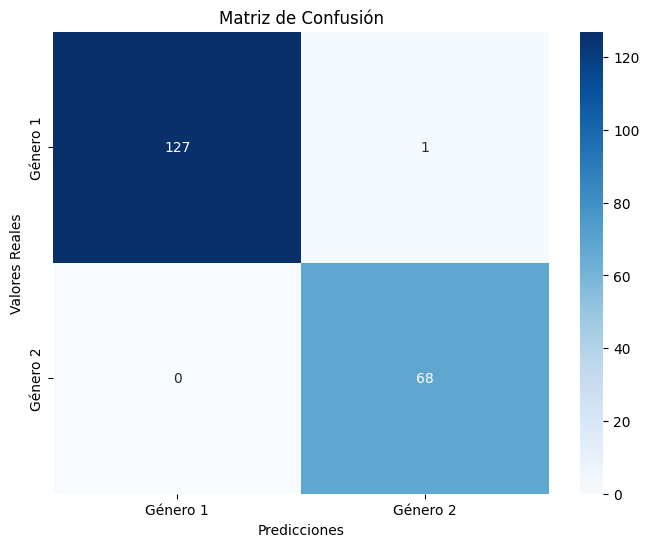

/tmp/ipykernel_33860/774559557.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='viridis')


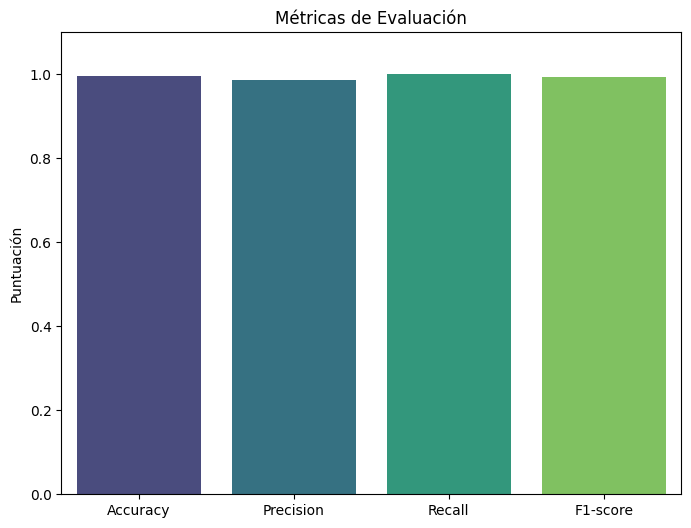

In [10]:


model.eval()
correct = 0
total = 0
all_predicted = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        inputs = {k: v.to(device).squeeze(1) for k, v in inputs.items()}
        labels = labels.to(device)

        outputs = model(**inputs)
        _, predicted = torch.max(outputs.logits, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = correct / total
precision = precision_score(all_labels, all_predicted)
recall = recall_score(all_labels, all_predicted)
f1 = f1_score(all_labels, all_predicted)
conf_matrix = confusion_matrix(all_labels, all_predicted)

# Imprimir métricas
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print('Confusion Matrix:')
print(conf_matrix)

# Classification Report
report = classification_report(all_labels, all_predicted, target_names=['Género 1', 'Género 2'])
print('Classification Report:')
print(report)

# 1. Gráfico de la Matriz de Confusión (Heatmap)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Género 1', 'Género 2'],
            yticklabels=['Género 1', 'Género 2'])
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.title('Matriz de Confusión')
plt.show()
 